#Data Preparation

##Unzip data

In [3]:
!unzip -q /content/valid.zip -d /content/
!mv /content/valid/ /content/data/

##Reading images and saving as numpy array

In [4]:
import numpy as np
from PIL import Image
import os

main_folder = '/content/data/'
image_data = []

subfolders = sorted(os.listdir(main_folder))

for folder in subfolders:
    folder_path = os.path.join(main_folder, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            if file.endswith('.jpg'):
                img = Image.open(file_path)
                rgb_data = np.array(img)
                image_data.append(rgb_data)

image_data = np.array(image_data)
print(image_data.shape)

print("\nArray order")
print("Blue:\timage_data[0:20]")
print("Gray:\timage_data[20:40]")
print("Green:\timage_data[40:60]")
print("Red:\timage_data[60:80]")
print("White:\timage_data[80:100]")

(100, 416, 416, 3)

Array order
Blue:	image_data[0:20]
Gray:	image_data[20:40]
Green:	image_data[40:60]
Red:	image_data[60:80]
White:	image_data[80:100]


#Extracting histograms

In [5]:
import numpy as np
import matplotlib.pyplot as plt

histograms_r = []
histograms_g = []
histograms_b = []

for i in range(len(image_data)):
    r = image_data[i][:, :, 0].flatten()
    g = image_data[i][:, :, 1].flatten()
    b = image_data[i][:, :, 2].flatten()

    hist_r, _ = np.histogram(r, bins=256, range=(0, 256))
    hist_g, _ = np.histogram(g, bins=256, range=(0, 256))
    hist_b, _ = np.histogram(b, bins=256, range=(0, 256))

    pixel_count = r.size
    hist_r = hist_r / pixel_count
    hist_g = hist_g / pixel_count
    hist_b = hist_b / pixel_count

    histograms_r.append(hist_r)
    histograms_g.append(hist_g)
    histograms_b.append(hist_b)

histograms_r = np.array(histograms_r)
histograms_g = np.array(histograms_g)
histograms_b = np.array(histograms_b)

print(histograms_r.shape)
print(histograms_g.shape)
print(histograms_b.shape)

(100, 256)
(100, 256)
(100, 256)


#Using Scikit KMeans function to compare results

In [6]:
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

feature_vectors = np.column_stack((histograms_r, histograms_g, histograms_b))

kmeans = KMeans(n_clusters=5, init='k-means++', algorithm='lloyd', n_init='auto')
kmeans.fit(feature_vectors)
predicted_clusters = kmeans.labels_

print(predicted_clusters)

[1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 4 4 1 4 1 4 0 4 3 1 4 1 1 1 1 4 2 4 4 2]


In [7]:
import pandas as pd
df = pd.DataFrame(feature_vectors)
df.to_csv("/content/data.csv")

In [70]:
import pandas as pd
import random
import seaborn as sns
import matplotlib.ticker
from matplotlib import pyplot as plt
from typing import List

df = pd.read_csv('/content/data.csv')

def distance(l1: List[float], l2: List[float]) -> float:
    assert len(l1) == len(l2)
    return sum([(a1 - a2)**2 for a1, a2 in zip(l1, l2)])

def clustering(df: pd.DataFrame, n_clusters: int) -> List[int]:
    columns = df.columns

    #assigning random values as centers
    ranges = [(0, 19), (20, 39), (40, 59), (60, 79), (80, 99)]
    coord_means = []
    for start, end in ranges:
      random_index = random.randint(start, end)
      coord_means.append(df.iloc[random_index])
    #coord_means = [[random.random() for _ in range(len(columns))] for _ in range(n_clusters)]
    # print(len(coord_means[0]))
    # print(coord_means)
    close_mean1 = pd.Series([-1 for _ in range(df.shape[0])])
    close_mean2 = pd.Series([-2 for _ in range(df.shape[0])])

    #stopping the learning process if not a single point changed cluster in the iteration
    while list(close_mean1) != list(close_mean2):
        close_mean1 = close_mean2
        close_mean2 = pd.Series([-1 for _ in range(df.shape[0])])

        #discovering closest centroid for every point
        for i in range(df.shape[0]):
            dist = []
            for coord_mean in coord_means:
                dist.append(distance(list(df.iloc[i,]), coord_mean))
            close_mean2[i] = dist.index(min(dist))

        #finding new coordinates for the next centers
        for j, coord_mean in enumerate(coord_means):
            if len(df[close_mean2 == j]) != 0:
                for k, column in enumerate(columns):
                    coord_mean[k] = df.loc[close_mean2 == j, column].mean()
            else:
                for k, column in enumerate(columns):
                    coord_mean[k] = random.random()

    return close_mean2

predicted_clusters2 = np.array(clustering(df, 5))
print(predicted_clusters2)

<ipython-input-70-bc466f597561>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coord_mean[k] = df.loc[close_mean2 == j, column].mean()


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


#Calculating accuracy

##General accuracy

In [71]:
from sklearn.metrics import accuracy_score

labels = np.repeat(np.arange(5), 20)

accuracy = accuracy_score(labels, predicted_clusters)
print(f"Library Kmeans Accuracy: {accuracy * 100:.2f}%")

accuracy = accuracy_score(labels, predicted_clusters2)
print(f"Manual Kmeans Accuracy: {accuracy * 100:.2f}%")

Library Kmeans Accuracy: 27.00%
Manual Kmeans Accuracy: 90.00%


##Class accuracy

In [72]:
from sklearn.metrics import accuracy_score

blue_mask = labels == 0
gray_mask = labels == 1
green_mask = labels == 2
red_mask = labels == 3
white_mask = labels == 4

accuracy_blue = accuracy_score(labels[blue_mask], predicted_clusters2[blue_mask])
accuracy_green = accuracy_score(labels[green_mask], predicted_clusters2[green_mask])
accuracy_gray = accuracy_score(labels[gray_mask], predicted_clusters2[gray_mask])
accuracy_white = accuracy_score(labels[white_mask], predicted_clusters2[white_mask])
accuracy_red = accuracy_score(labels[red_mask], predicted_clusters2[red_mask])

print(f"Accuracy for blue: {accuracy_blue * 100:.2f}%")
print(f"Accuracy for gray: {accuracy_gray * 100:.2f}%")
print(f"Accuracy for green: {accuracy_green * 100:.2f}%")
print(f"Accuracy for red: {accuracy_red * 100:.2f}%")
print(f"Accuracy for white: {accuracy_white * 100:.2f}%")

Accuracy for blue: 100.00%
Accuracy for gray: 90.00%
Accuracy for green: 85.00%
Accuracy for red: 85.00%
Accuracy for white: 90.00%


##Confusion Matrix

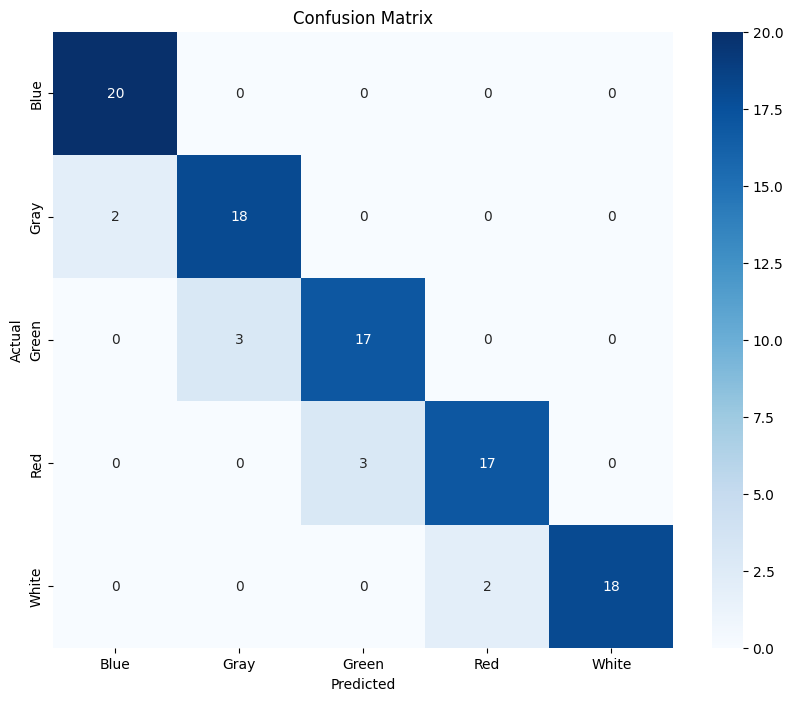

In [73]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

label_names = ['Blue', 'Gray', 'Green', 'Red', 'White']

conf_matrix = confusion_matrix(labels, predicted_clusters2)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',  xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#Displaying Clustered Images

##Finding matched and mismatched indexes

In [89]:
import numpy as np

mismatched_indexes = np.where(labels != predicted_clusters2)[0]
mismatched_labels = labels[mismatched_indexes]

print("Mismatched labels:", mismatched_labels)
print("Mismatched indexes:", mismatched_indexes)

Mismatched labels: [1 1 2 2 2 3 3 3 4 4]
Mismatched indexes: [20 21 40 41 42 60 61 62 80 81]


In [101]:
import numpy as np

bonk=[]
class_size = 20
class_ranges = [(i * class_size, (i + 1) * class_size) for i in range(5)]

mismatched_indexes = np.where(labels != predicted_clusters2)[0]
other_class_indexes = []

for start, end in class_ranges:
    class_indexes = np.arange(start, end)
    other_indexes = np.setdiff1d(class_indexes, mismatched_indexes)
    other_class_indexes.append(other_indexes)

for i, indexes in enumerate(other_class_indexes):
    output = np.random.choice(indexes, size=min(5, len(indexes)), replace=False)
    bonk.append(output)
    print(f"Class {i + 1} indexes (excluding mismatches):")
    print(output)
    print("----")

Class 1 indexes (excluding mismatches):
[15  6  0 11  5]
----
Class 2 indexes (excluding mismatches):
[35 26 31 25 28]
----
Class 3 indexes (excluding mismatches):
[51 45 55 52 54]
----
Class 4 indexes (excluding mismatches):
[66 64 69 67 65]
----
Class 5 indexes (excluding mismatches):
[89 97 85 88 84]
----


##Displaying 5 correctly clustered images for each class

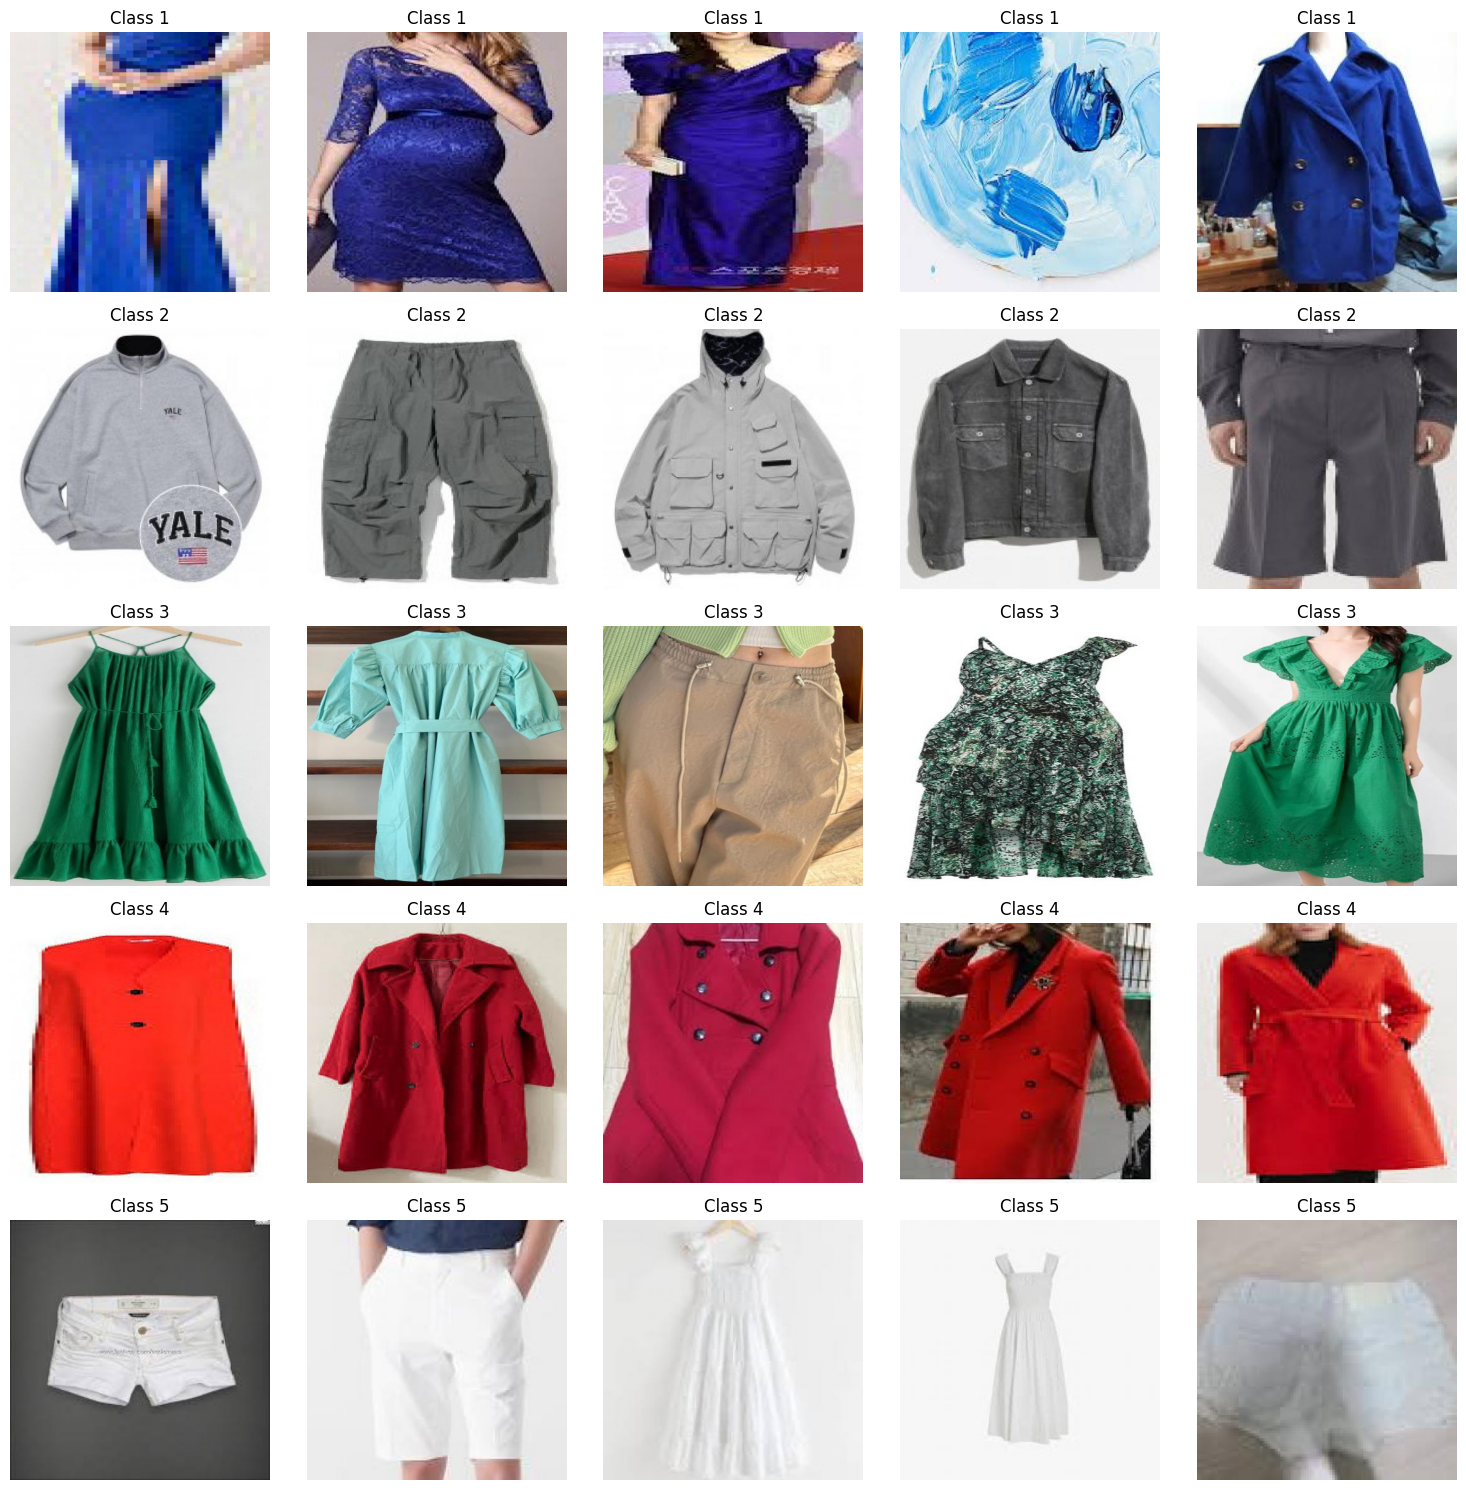

In [121]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 5, figsize=(15, 15))  # 5x5 grid for 5 classes

for i in range(5):
    for j in range(5):
        idx = bonk[i][j]
        axes[i, j].imshow(image_data[idx])
        axes[i, j].set_title(f"Class {i + 1}")
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()